In [31]:
import json, time, urllib.parse
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

Part 1: Data Acquisition: Steps detailed for gathering data of pageviews for a list of pages from a database of rare diseases maintained by the National Organization for Rare Diseases (NORD).

Step 1 - Gather the list of titles for API query \
Step 2 - Create a function to hit the API endpoint and get the required data \
Step 3 - Format the data recieved by API ednpoint so that mobile-app and mobile-web data is combined and a final json file is saved

In [3]:
# Step 1: Acquire article titles from rare disease data 

def get_titles(csv_file):
    """Takes in a csv file and returns column with desired article titles in list format"""
    return list(pd.read_csv(csv_file)['disease'])

In [3]:
# Step 2: Get pageviews for different access types using Wikimedia API 

# API Request template

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. 
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

REQUEST_HEADERS = {
    'User-Agent': '<insert email ID here>'
}

ARTICLE_TITLES = get_titles("rare-disease_cleaned.AUG.2024.csv")

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. 
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2024100300"    # this is likely the wrong end date
}

def request_pageviews_per_article(article_title = None, access_type=None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")
    
    if access_type:
        request_template['access'] = access_type

    if not request_template['access']:
        request_template['access'] = "all-access" # Setting all-access as default   

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe="") # Adding safe parameter to be able to read titles with backslashes 
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [5]:
# Step 3: Call API and generate desired json files

def generate_json_files(article_titles, start_date, end_date):
    mobile_access_data = {}
    desktop_access_data = {}
    cumulative_access_data = {}

    for title in article_titles:
        print(f"Getting pageview data for: {title}")

        # Request mobile-web and mobile-app data, then sum them per month
        mobile_web_views = request_pageviews_per_article(title, 'mobile-web')
        mobile_app_views = request_pageviews_per_article(title, 'mobile-app')
        if mobile_web_views and mobile_app_views:
            mobile_views_per_month = {} # initialize object to store updated value
            try:
                for item in mobile_web_views['items']:
                    month = item['timestamp']
                    item.pop('access', None)  # Remove 'access' field
                    if month not in mobile_views_per_month:
                        mobile_views_per_month[month] = item
                    else:
                        mobile_views_per_month[month]['views'] += item['views']
                for item in mobile_app_views['items']:
                    month = item['timestamp']
                    item.pop('access', None)  # Remove 'access' field
                    if month not in mobile_views_per_month:
                        mobile_views_per_month[month] = item
                    else:
                        mobile_views_per_month[month]['views'] += item['views']
                mobile_access_data[title] = list(mobile_views_per_month.values())
            except Exception as e:
                print(e)
                continue

        # Request desktop data and store per month
        desktop_views = request_pageviews_per_article(title, 'desktop')
        if desktop_views:
            desktop_access_data[title] = desktop_views['items']
            for item in desktop_access_data[title]:
                item.pop('access', None)  # Remove 'access' field

        # Request cumulative data using all-access
        all_access_views = request_pageviews_per_article(title, 'all-access')
        if all_access_views:
            cumulative_access_data[title] = all_access_views['items']
            for item in cumulative_access_data[title]:
                item.pop('access', None)  # Remove 'access' field


    # Save JSON files
    with open(f"datasets/rare-disease_monthly_mobile_{start_date}-{end_date}.json", 'w') as f:
        json.dump(mobile_access_data, f)
    with open(f"datasets/rare-disease_monthly_desktop_{start_date}-{end_date}.json", 'w') as f:
        json.dump(desktop_access_data, f)
    with open(f"datasets/rare-disease_monthly_cumulative_{start_date}-{end_date}.json", 'w') as f:
        json.dump(cumulative_access_data, f)

In [6]:
# Set the date range for the analysis
start_date = "201501"
end_date = "202409"

# Generate the JSON files for the pageview data
article_titles = get_titles("rare-disease_cleaned.AUG.2024.csv")
generate_json_files(article_titles, start_date, end_date)

Getting pageview data for: Klinefelter syndrome
Getting pageview data for: Aarskog–Scott syndrome
Getting pageview data for: Abetalipoproteinemia
Getting pageview data for: MT-TP
Getting pageview data for: Ablepharon macrostomia syndrome
Getting pageview data for: Acanthocheilonemiasis
Getting pageview data for: Acanthosis nigricans
Getting pageview data for: Aceruloplasminemia
Getting pageview data for: Megaesophagus
Getting pageview data for: Achard–Thiers syndrome
Getting pageview data for: Achondrogenesis
Getting pageview data for: Achondroplasia
Getting pageview data for: Dwarfism
Getting pageview data for: Osteochondrodysplasia
Getting pageview data for: Fibroblast growth factor receptor 3
Getting pageview data for: Vestibular schwannoma
Getting pageview data for: Brain tumor
Getting pageview data for: Acquired generalized lipodystrophy
Getting pageview data for: Barraquer–Simons syndrome
Getting pageview data for: Acrodermatitis enteropathica
Getting pageview data for: Zinc defi

Part 2: Data Analysis

Loading datasets, creating dataframes and pulling relevant time series for plotting and visualization

In [32]:
# Load the datasets
with open("datasets/rare-disease_monthly_desktop_201501-202409.json",'r') as f:
    desktop_data = json.load(f)
with open("datasets/rare-disease_monthly_mobile_201501-202409.json",'r') as f:
    mobile_data = json.load(f)

In [33]:
# Create flattened dataframes

desktop_data_list = []
for k,v in desktop_data.items():
    desktop_data_list.append(pd.DataFrame(v))
desktop_data_df = pd.concat(desktop_data_list)
 
mobile_data_list= []
for k,v in mobile_data.items():
    mobile_data_list.append(pd.DataFrame(v))
mobile_data_df = pd.concat(mobile_data_list)

In [34]:
# Converting to month-wise timestamps

desktop_data_df['timestamp'] = desktop_data_df['timestamp'].apply(lambda x: x[:6])
mobile_data_df['timestamp'] = mobile_data_df['timestamp'].apply(lambda x: x[:6])

2.1 Maximum Average and Minimum Average - The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. 

In [35]:
# Aggregate to obtain average views per article
desktop_agg = desktop_data_df.groupby('article').agg({'views' : 'mean'})
mobile_agg = mobile_data_df.groupby('article').agg({'views' : 'mean'})

In [36]:
# Obtain article for each access type with minimum and maximum average views 

min_max_dict = {'Max_desktop': desktop_agg[desktop_agg['views'] == max(desktop_agg['views'])].index[0],
                'Min_desktop': desktop_agg[desktop_agg['views'] == min(desktop_agg['views'])].index[0],
                'Max_mobile': mobile_agg[mobile_agg['views'] == max(mobile_agg['views'])].index[0],
                'Min_mobile': mobile_agg[mobile_agg['views'] == min(mobile_agg['views'])].index[0]}

# Use the names of the relevant articles to pull time series data from original dataframe and plot it
plot_data = {}
for k,v in min_max_dict.items():
    if "desktop" in k:
        plot_data[f'{k} : {v}'] = desktop_data_df[desktop_data_df['article'] == v][['timestamp', 'views']]
    else:
        plot_data[f'{k} : {v}'] = mobile_data_df[mobile_data_df['article'] == v][['timestamp', 'views']]

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


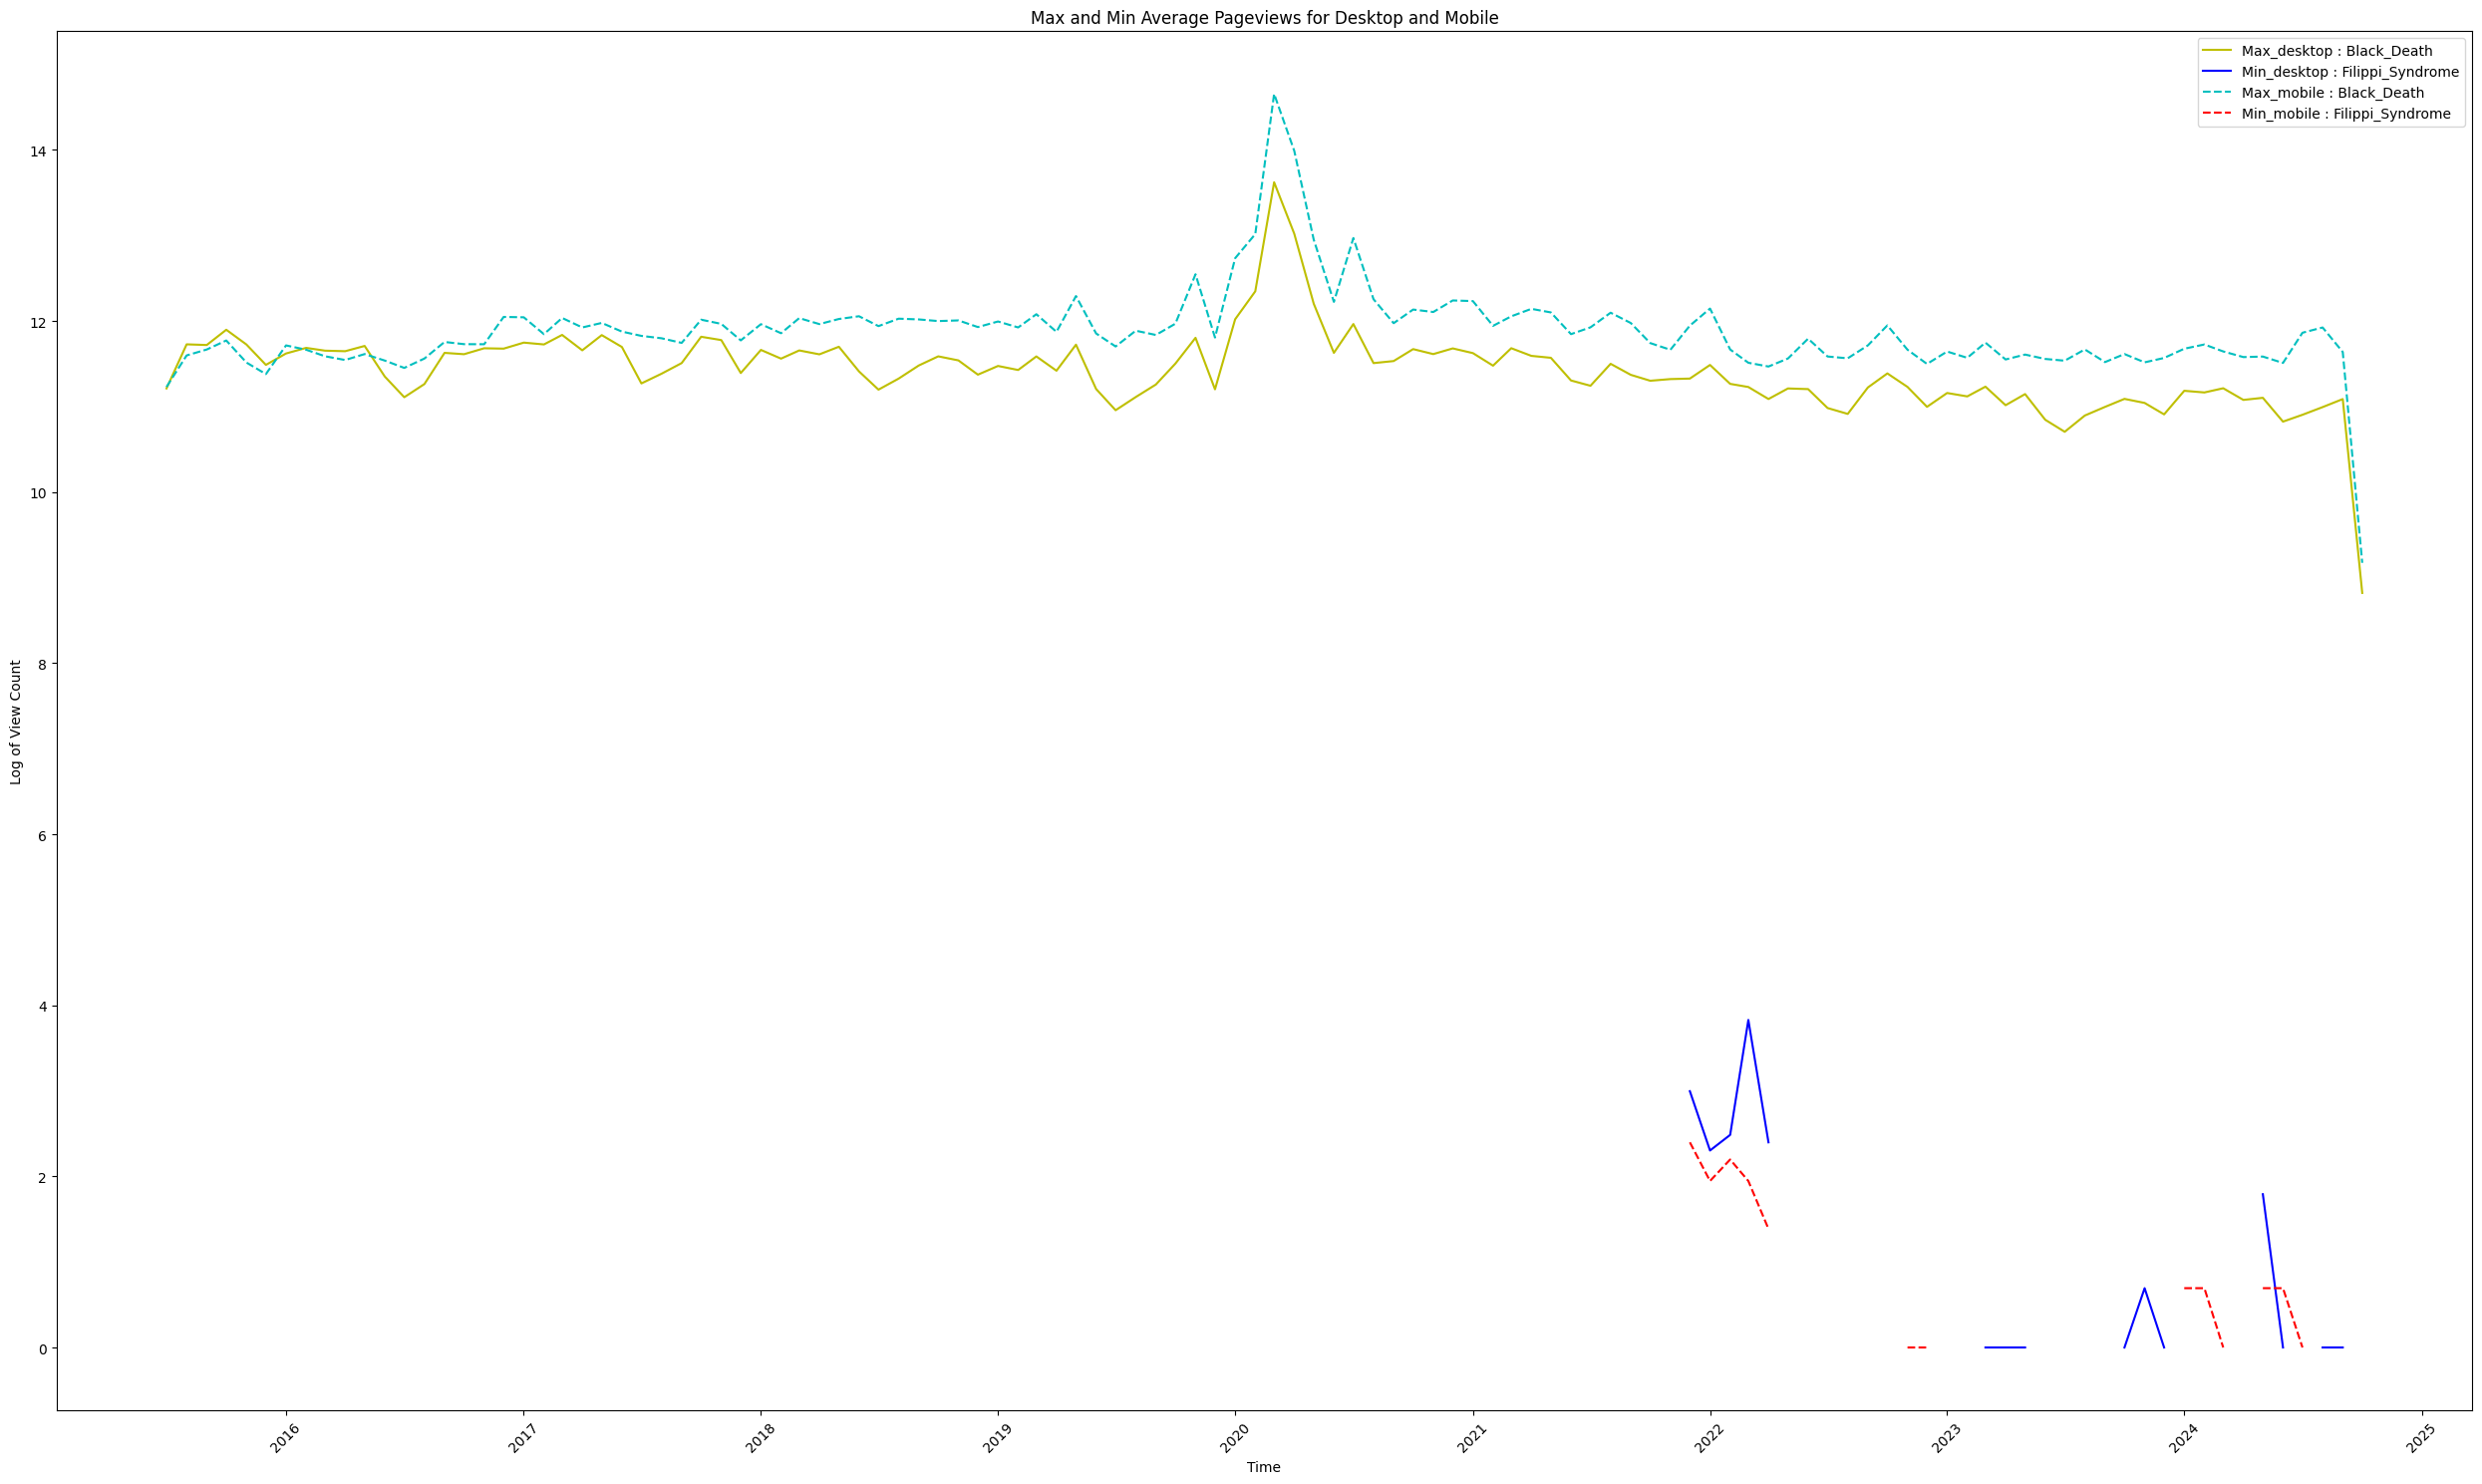

In [37]:
"""Note: GPT-generated plotting code

Prompt used: Given a dictionary with keys that are strings and values that are pandas dataframes containing 2 columns, 
a timestamp and the number of views, help plot a graph that visualizes the time series data contained in the dataframe 
for each key on the same plot

Supplementary prompt: modify the code a little bit to customize the colours for each key and the linestyle based 
on whether the key includes the string desktop or not"""

plt.figure(figsize=(25,15))

colors = itertools.cycle(['y', 'b', 'c', 'r', 'm'])  # Cycle through a set of colors

for key, df in plot_data.items():
    # Assuming timestamp is in datetime format or needs conversion
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m')
    
    linestyle = '-' if 'desktop' in key.lower() else '--'
    color = next(colors)
    plt.plot(df['timestamp'], np.log(df['views']), label=key, linestyle=linestyle, color=color) # using log scale for clear visualizations

plt.xlabel('Time')
plt.ylabel('Log of View Count')
plt.title('Max and Min Average Pageviews for Desktop and Mobile')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("imgs/min-max-avg-pageviews.png") # Save before show https://stackoverflow.com/questions/31974373/how-to-save-pyplot-figure
plt.show()

2.2 Top 10 Peak Page Views - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time series by access type.

In [38]:
# Find the article titles with most number of views for each access type

top_10_desktop = desktop_data_df.sort_values('views',ascending=False)['article'].unique()[:10]
top_10_mobile = mobile_data_df.sort_values('views',ascending=False)['article'].unique()[:10]

In [39]:
# Pull time series data of relevant titles 

plot_peak_data = {}
for rank, article_title in enumerate(top_10_desktop):
    plot_peak_data[f"Desktop #{rank + 1}: {article_title}"] = desktop_data_df[desktop_data_df['article'] == article_title][['timestamp', 'views']]
for rank, article_title in enumerate(top_10_mobile):
    plot_peak_data[f"Mobile #{rank + 1}: {article_title}"] = mobile_data_df[mobile_data_df['article'] == article_title][['timestamp', 'views']]

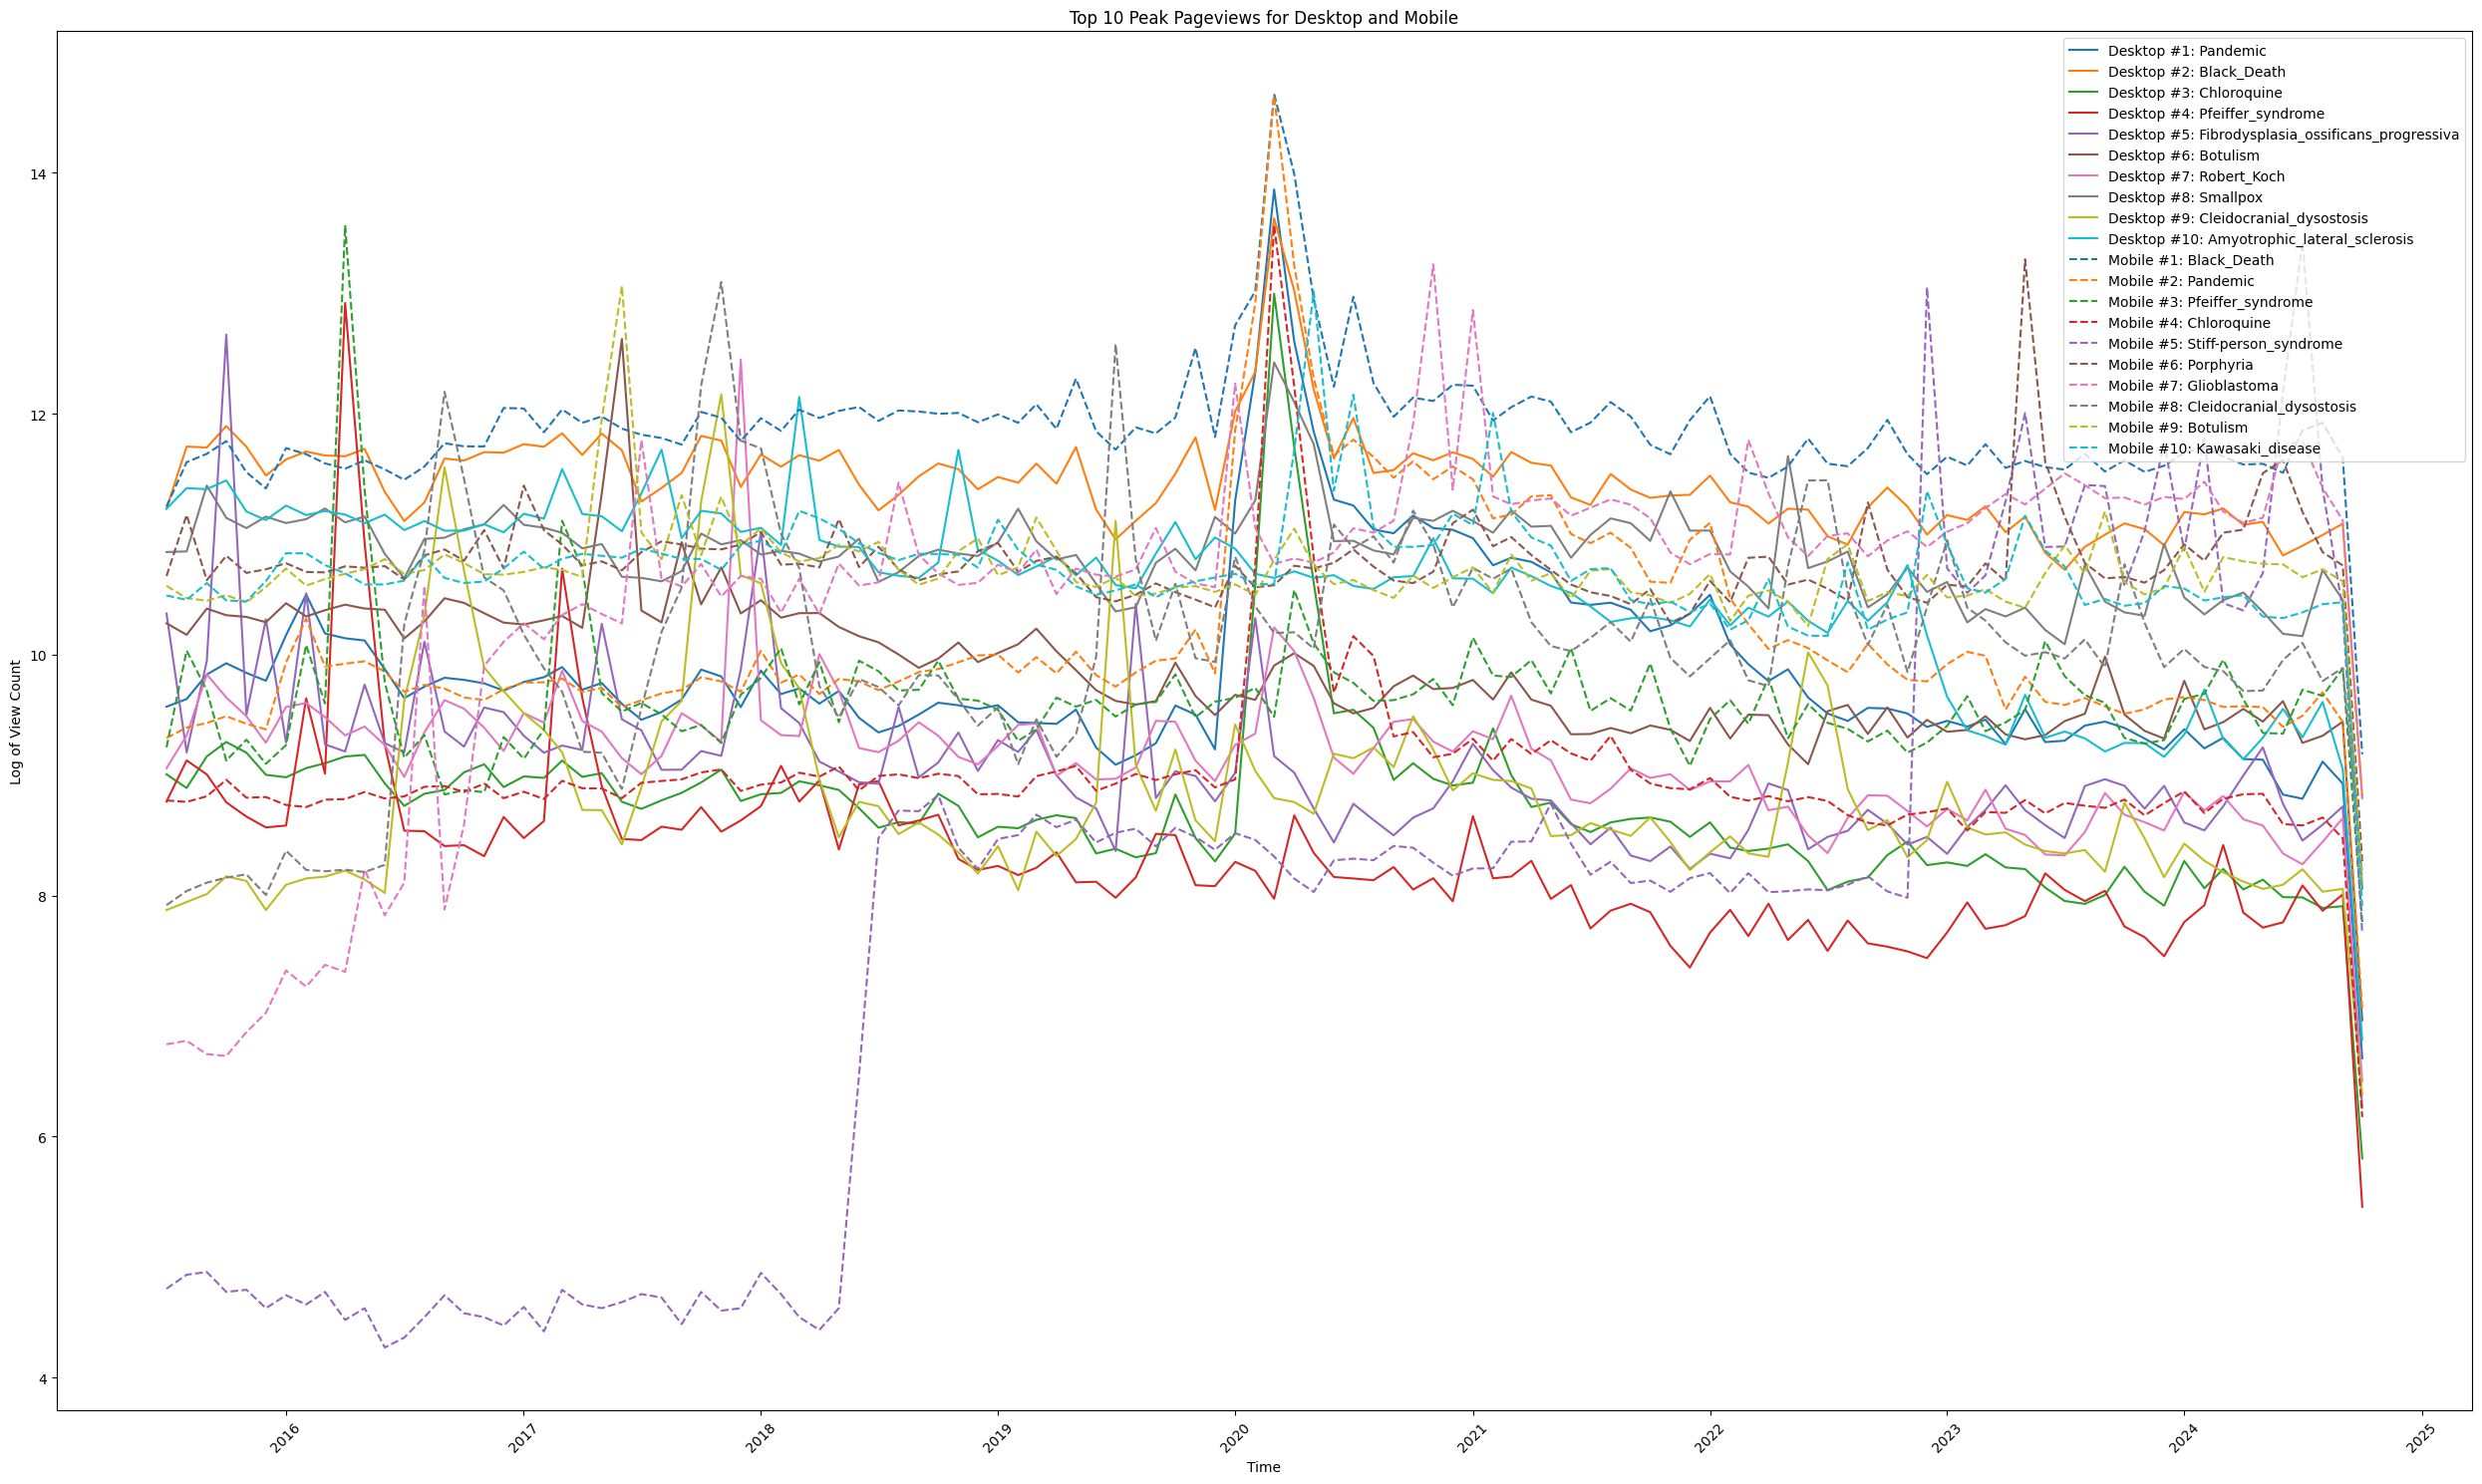

In [40]:
"""Note: GPT-generated plotting code

Prompt used: Given a dictionary with keys that are strings and values that are pandas dataframes containing 2 columns, 
a timestamp and the number of views, help plot a graph that visualizes the time series data contained in the dataframe 
for each key on the same plot

Supplementary prompt: modify the code a little bit to customize the colours for each key and the linestyle based 
on whether the key includes the string desktop or not"""

plt.figure(figsize=(25,15))

for key, df in plot_peak_data.items():
    # Assuming timestamp is in datetime format or needs conversion
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m')
    
    linestyle = '-' if 'desktop' in key.lower() else '--'
    plt.plot(df['timestamp'], np.log(df['views']), label=key, linestyle=linestyle) # using log scale for clear visualizations

plt.xlabel('Time')
plt.ylabel('Log of View Count')
plt.title('Top 10 Peak Pageviews for Desktop and Mobile')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("imgs/top-10-pageviews.png") # Save before show https://stackoverflow.com/questions/31974373/how-to-save-pyplot-figure
plt.show()

2.3 Fewest Months of Data - The third graph should show pages that have the fewest months of available data.

In [41]:
# Find the article titles with fewest months of data for each access type

fewest_months_desktop = desktop_data_df['article'].value_counts().sort_values()[:10].to_dict()
fewest_months_mobile = mobile_data_df['article'].value_counts().sort_values()[:10].to_dict()

In [42]:
# Pull time series data of relevant titles 

plot_fewest_months_data = {}
for key,val in fewest_months_desktop.items():
    plot_fewest_months_data[f"Desktop ({val} months): {key}"] = desktop_data_df[desktop_data_df['article'] == key][['timestamp', 'views']]
for key,val in fewest_months_mobile.items():
    plot_fewest_months_data[f"Mobile ({val} months): {key}"] = mobile_data_df[mobile_data_df['article'] == key][['timestamp', 'views']]

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in l

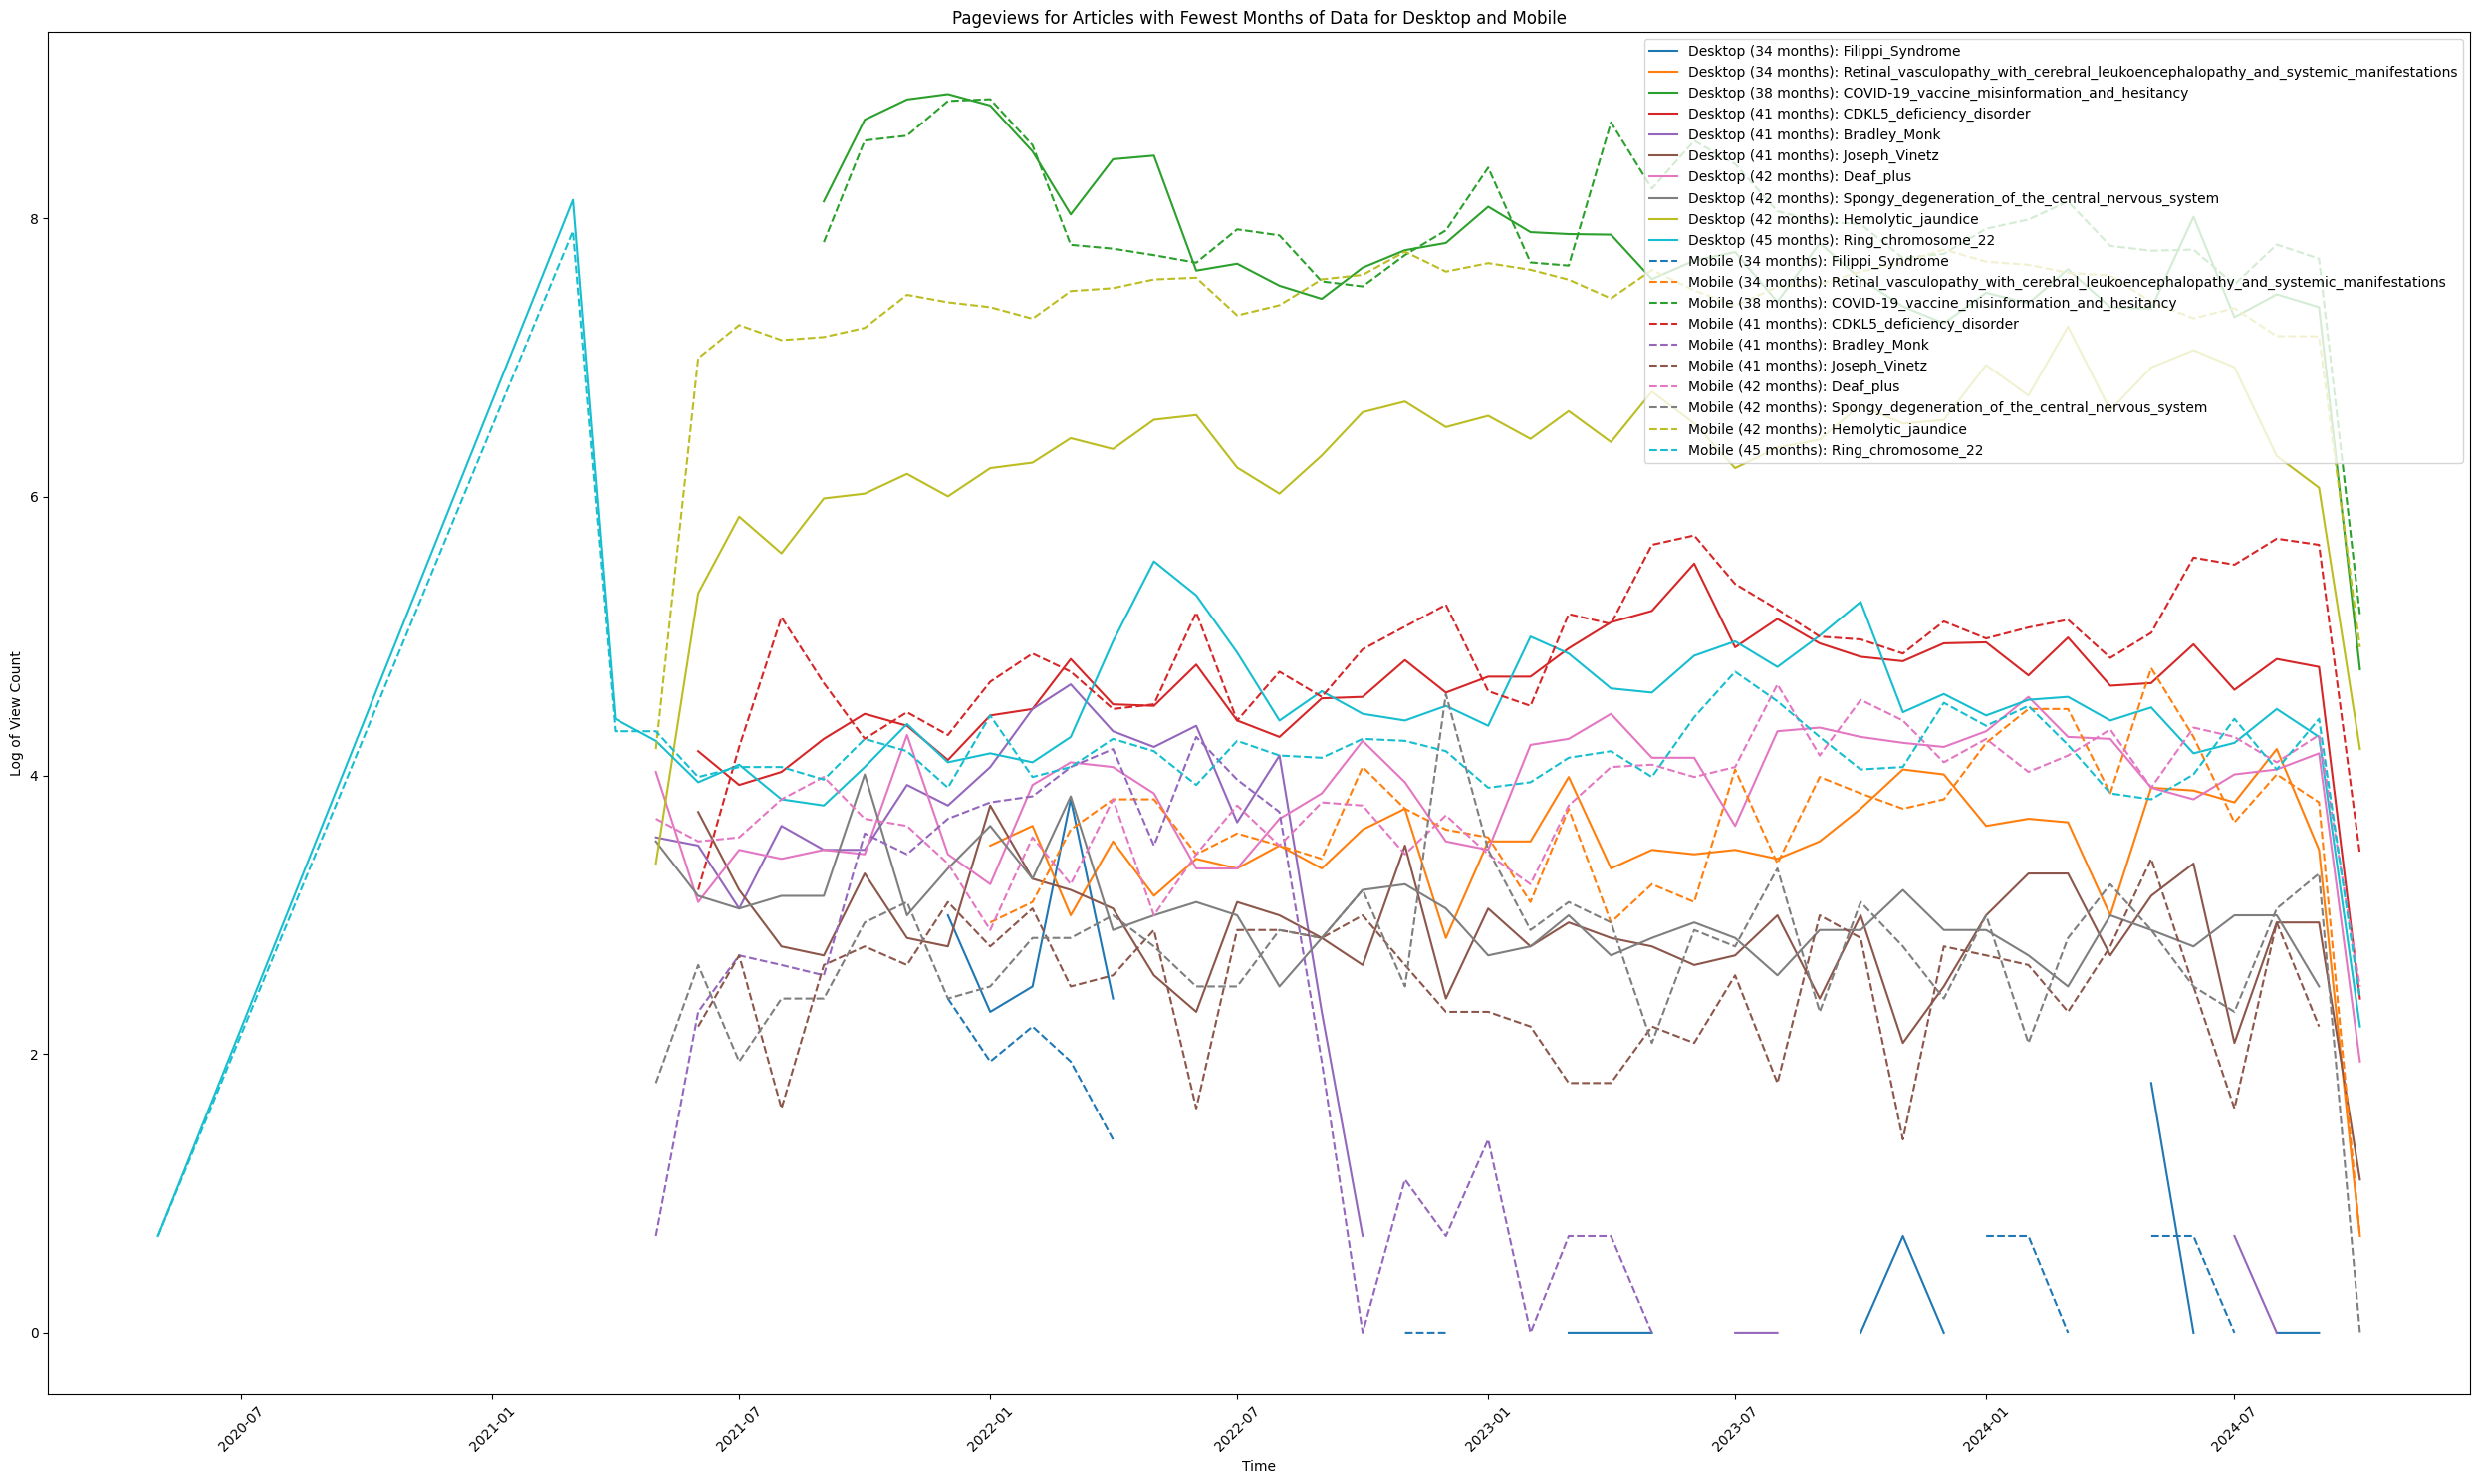

In [43]:
"""Note: GPT-generated plotting code

Prompt used: Given a dictionary with keys that are strings and values that are pandas dataframes containing 2 columns, 
a timestamp and the number of views, help plot a graph that visualizes the time series data contained in the dataframe 
for each key on the same plot

Supplementary prompt: modify the code a little bit to customize the colours for each key and the linestyle based 
on whether the key includes the string desktop or not"""

plt.figure(figsize=(25,15))

for key, df in plot_fewest_months_data.items():
    # Assuming timestamp is in datetime format or needs conversion
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m')
    
    linestyle = '-' if 'desktop' in key.lower() else '--'
    plt.plot(df['timestamp'], np.log(df['views']), label=key, linestyle=linestyle) # using log scale for clear visualizations

plt.xlabel('Time')
plt.ylabel('Log of View Count')
plt.title('Pageviews for Articles with Fewest Months of Data for Desktop and Mobile')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("imgs/fewest-months.png") # Save before show https://stackoverflow.com/questions/31974373/how-to-save-pyplot-figure
plt.show()